# Evaluation-Driven Development (EDD) with MLflow & LangChain

## What You'll Learn

In this hands-on workshop, we'll master **Evaluation-Driven Development (EDD)** for GenAI applications—a systematic approach to building reliable AI systems through continuous, automated evaluation.

### Learning Objectives
- **Understand EDD Philosophy**: Why rigorous evaluation should drive development decisions
- **Build RAG Evaluation Pipelines**: Evaluate retrieval quality, relevance, and correctness
- **Evaluate Agentic Systems**: Measure tool usage efficiency and task completion
- **Design Effective Test Cases**: Create realistic scenarios that catch edge cases
- **Instrument Traces for Insights**: Use MLflow to capture and analyze agent behavior

### What We'll Build Today

**Scenario 1: RAG System Evaluation**
- A product support bot that retrieves relevant device specifications
- Evaluates retrieval quality (did it find the RIGHT documents?)
- Evaluates answer correctness (did it synthesize the right answer?)
- Tests multi-hop reasoning (questions requiring multiple document types)

**Scenario 2: Agent System Evaluation**
- A CMS manager agent that searches, retrieves details, and publishes articles
- Evaluates task completion (did it accomplish the goal?)
- Analyzes tool trajectories (did it use tools efficiently and follow SOP?)
- Validates decision-making (does it avoid redundant operations?)

### Prerequisites

✓ **Environment Setup:**
- Python 3.10+ installed
- `OPENAI_API_KEY` set in environment or `.env` file
- All dependencies installed (see Import Setup below)

✓ **Recommended Background:**
- Familiarity with LangChain or LLM chains
- Basic understanding of RAG concepts
- Comfort with Python and Jupyter notebooks

### How to Use This Notebook

This notebook is designed as a **follow-along** conference presentation:
1. Read the **Context & Explanation** sections to understand concepts
2. Run **Code cells** in sequence (don't skip!)
3. Check **Outputs** to verify each step is working
4. At key points, **pause and experiment**—modify prompts, test cases, or parameters
5. Refer to the **Next Steps** section at the end for real-world application

# Part 0: Setup & Environment Configuration

## Install & Import Dependencies

In [1]:
# !uv sync

In [2]:
# Install dependencies if running in Colab or a fresh environment
#%pip install -q "mlflow>=2.14" langgraph langchain langchain-openai langchain-community langchain-text-splitters faiss-cpu pandas openai python-dotenv bs4

In [3]:
import mlflow
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
import os
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent

from mlflow.genai.scorers import (
    Correctness,
    RelevanceToQuery,
    Guidelines,
)
from mlflow.entities import Feedback, SpanType, Trace
from mlflow.genai import scorer
from deepeval.metrics import TaskCompletionMetric
from deepeval.test_case import LLMTestCase, ToolCall
import json
from deepeval.metrics import ContextualRelevancyMetric



from dotenv import load_dotenv

print(f"MLflow version: {mlflow.__version__}")

MLflow version: 3.6.0


In [4]:
# Load API Key
load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API Key: ")

# Set a specific experiment for this notebook
mlflow.set_experiment("GenAI_Eval_Demo")

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///Users/pedro.azevedo/dspt-mlflow/mlruns/413835162552422093', creation_time=1763905836235, experiment_id='413835162552422093', last_update_time=1763905836235, lifecycle_stage='active', name='GenAI_Eval_Demo', tags={}>

## Part 1: RAG Evaluation

We will build a simple RAG chain that answers questions about software tools. We will then evaluate it using MLflow's **"Trace Required"** judges, which inspect the actual retrieved documents to ensure relevance and groundedness.

In [5]:
# 1. Enable Autologging
mlflow.langchain.autolog()

## Understanding MLflow Traces: Foundation for Evaluation

When an agent runs, MLflow captures the **entire execution journey** in a hierarchical structure called a **Trace**:

```
Trace (entire execution)
├── Span: LLM Call (to ChatGPT)
├── Span: Tool Call (search_articles)
│   ├── Input: {"query": "summer"}
│   ├── Output: [{"id": "102", "title": "Summer Recipes"}]
│   └── Duration: 234ms
├── Span: Tool Call (get_article_details)
│   ├── Input: {"article_id": "102"}
│   ├── Output: {"title": "...", "status": "published"}
│   └── Duration: 156ms
└── Span: LLM Call (synthesis)
```

**Why Extract Traces?** 
When we evaluate agents, we need to verify not just the final answer, but also:
- Which documents were retrieved (for RAG correctness)
- Which tools were called and in what order (for tool trajectory analysis)
- What decisions the agent made based on tool outputs

The functions below parse these nested trace structures to extract the specific data needed for evaluation.

### Helper Functions: Parsing Trace Data

In [6]:


def extract_source_nodes(json_input):
    """
    Parses a JSON string containing a message history and extracts source nodes
    from tool artifacts.
    """
    try:
        parsed_data = json.loads(json_input)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return []

    # Handle the structure: {"messages": [...]}
    messages = parsed_data.get("messages", []) if isinstance(parsed_data, dict) else []
    
    source_nodes = []
    
    for message in messages:
        # We are looking for messages where type is 'tool' and an 'artifact' list exists
        if message.get("type") == "tool" and "artifact" in message:
            artifacts = message["artifact"]
            
            # Ensure artifact is a list before extending our results
            if isinstance(artifacts, list):
                source_nodes.extend(artifacts)
                
    return source_nodes

def extract_final_response(json_input):
    """
    Parses a JSON string and extracts the content of the final AI response.
    """
    try:
        parsed_data = json.loads(json_input)
    except json.JSONDecodeError:
        return None

    messages = parsed_data.get("messages", []) if isinstance(parsed_data, dict) else []
    
    # Iterate backwards to find the most recent AI message with content
    for message in reversed(messages):
        if message.get("type") == "ai" and message.get("content"):
            return message["content"]
            
    return None

def _extract_deepeval_components(trace : Trace):
    """Extract input, output, and context from trace data"""
    request = str(trace.data.request)
    response = str(trace.data.response)

    # extract source nodes if they exist
    # Extract Source Nodes
    outputs = extract_source_nodes(response)
    retrieval_context = [node['page_content'] for node in outputs]
    
    
    actual_output = extract_final_response(response)

    return {
        'input': request,
        'actual_output': actual_output,
        'retrieval_context': retrieval_context
    }




---

# Part 1: RAG Evaluation – Building a Product Support Bot

## 1.1 Scenario: Evaluating Retrieval-Augmented Generation

**Problem:** We have a knowledge base of product specifications. We want to verify that when users ask questions, the bot:
1. ✓ Retrieves the **correct** documents
2. ✓ Uses retrieved information to **answer correctly**
3. ✓ Handles **multi-hop** questions (requiring info from multiple documents)

**Example Multi-Hop Question:**
- User: *"Can I use the Orbit Watch Pro with the Orbit Phone X10?"*
- Requires retrieving: Phone specs (OS version) + Watch specs (OS requirements)
- Bad retrieval: Only returns Watch specs → Can't verify compatibility
- Good retrieval: Returns both → Can verify match

**Our Approach:**
- Build a simple retriever with 5 product documents
- Create test cases that require multi-hop reasoning
- Define scorers that check both retrieval quality AND answer correctness
- Use MLflow to track and compare evaluation runs

---

## 1.2 Creating the Knowledge Base

We'll define product specifications as exact string variables. **This is crucial for evaluation**: 
when we later verify what was retrieved, we'll compare against these exact strings to ensure perfect traceability.

In [7]:
# 1. Define content as variables to ensure 100% match between VectorStore and Eval Dataset
rag_content_phone = "Orbit Phone X10 Specs: Runs OrbitOS 4.0, uses USB-C charging port, supports 5G, release date Jan 2024."
rag_content_watch = "Orbit Watch Pro Specs: Requires phone running OrbitOS 4.0 or higher to sync. Battery life 24h."
rag_content_buds = "Orbit Buds Lite Specs: Connects via Bluetooth 5.0. Compatible with any device supporting Bluetooth."
rag_content_old_charger = "Legacy Charger Adapter: This adapter converts Micro-USB to USB-C. Max output 5W."
rag_content_new_charger = "Orbit FastCharger: Native USB-C charger. Output 30W. Required for fast charging on X10."

rag_docs = [
    Document(page_content=rag_content_phone, metadata={"id": "doc_1"}),
    Document(page_content=rag_content_watch, metadata={"id": "doc_2"}),
    Document(page_content=rag_content_buds, metadata={"id": "doc_3"}),
    Document(page_content=rag_content_old_charger, metadata={"id": "doc_4"}),
    Document(page_content=rag_content_new_charger, metadata={"id": "doc_5"}),
]

# Create Vector Store & Retriever
vectorstore = FAISS.from_documents(rag_docs, OpenAIEmbeddings())
retriever = vectorstore.as_retriever(k=1)

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vectorstore.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs



## 1.3 Building the RAG Agent

### Key Design: response_format="content_and_artifact"

LangChain tools can return data in two formats:
- **content**: Human-readable text for the agent's reasoning
- **artifact**: Structured data (like Document objects) for downstream processing

By using `response_format="content_and_artifact"`, we tell MLflow to:
1. Log the readable content for the agent
2. **Also capture the raw artifacts** (the actual retrieved Documents) separately

This is essential for evaluation—we'll later verify not just that the agent answered well, but that it used the RIGHT documents.

### The Tool: Retrieve Context

In [8]:
rag_system_prompt = (
    "You are the Orbit Electronics Support Bot. "
    "For every user question, you must retrieve specifications for ALL devices mentioned. "
    "Synthesize the answer based ONLY on the retrieved text."
)

model = init_chat_model("gpt-4.1")
tools = [retrieve_context]


rag_agent = create_agent(model, tools, system_prompt=rag_system_prompt)

def qa_predict_rag_fn(query: str) -> str:
    response = rag_agent.invoke({
        "messages": [{"role": "user", "content": query}],
    })
    answer = response['messages'][-1].content
    return answer

### Wrapping the Agent: qa_predict_rag_fn

Our prediction function wraps the agent with:
- Consistent input formatting (user message)
- Extraction of final response (from the last AI message)
- Logging to MLflow (autolog captures traces automatically)

This is the function we'll pass to `mlflow.genai.evaluate()` later.

In [9]:
qa_predict_rag_fn("What charger do I need for the Orbit Phone X10?")

'The Orbit Phone X10 uses a USB-C charging port. For fast charging, you need the Orbit FastCharger, which is a native USB-C charger with a 30W output.'

### Testing the Agent: Quick Sanity Check

Let's verify the agent works before we run the full evaluation:

## 1.4 Designing Test Cases: The RAG Evaluation Dataset

### Why Multi-Hop Test Cases Matter

**Single-hop questions** (e.g., *"What's the battery life of the Orbit Watch Pro?"*):
- Easy for RAG systems: retrieve one document, extract answer
- Limited signal: doesn't test retrieval quality or reasoning

**Multi-hop questions** (e.g., *"Can I use the Orbit Watch Pro with the Orbit Phone X10?"*):
- Requires retrieving MULTIPLE document types
- Tests both retrieval quality AND reasoning
- Better indicator of real-world performance

### Test Case Design Strategy

For each test case, we specify:
- **Input**: User query
- **Expected Response**: What the answer should contain
- **Expected Facts**: Which documents MUST be retrieved (verbatim strings)
- **Retrieval Context**: The actual context to verify against

Notice: We use the **exact same strings** (`rag_content_phone`, `rag_content_watch`) that we put in the vector store. This ensures perfect traceability—we can verify the agent retrieved the right documents.

In [10]:
rag_eval_dataset = [
    # Case 1: Multi-hop Compatibility
    # Logic: User asks about Watch + Phone. 
    # Requirement: Must retrieve Phone Specs (OS version) AND Watch Specs (OS requirement).
    {
        "inputs": {"query": "Can I use the Orbit Watch Pro with the Orbit Phone X10?"},
        "expectations": {
            "expected_response": "Yes. The Orbit Phone X10 runs OrbitOS 4.0, which matches the Orbit Watch Pro's requirement.",
            # VERBATIM MATCHES:
            "expected_facts": [rag_content_phone, rag_content_watch],
            "retrieval_context": [rag_content_phone, rag_content_watch] 
        }
    },
    # Case 2: Multi-hop Power/Charging
    # Logic: User has Old Charger + New Phone. 
    # Requirement: Must retrieve Old Charger Specs (5W) AND New Charger Specs (Requirement for Fast Charge).
    {
        "inputs": {"query": "Will the Legacy Charger Adapter allow me to fast charge my Orbit Phone X10?"},
        "expectations": {
            "expected_response": "No. The Legacy Adapter output is 5W, but the X10 requires 30W (Orbit FastCharger) to fast charge.",
            # VERBATIM MATCHES:
            "expected_facts": [rag_content_old_charger, rag_content_new_charger],
            "retrieval_context": [rag_content_old_charger, rag_content_new_charger]
        }
    }
]

## 1.5 Configuring Evaluation Metrics: Scorers & Judges

### Understanding Our Three Scorers

| Scorer | What It Measures | When to Use |
|--------|------------------|-------------|
| **Correctness** | Is the answer factually correct? | Always—baseline quality metric |
| **RelevanceToQuery** | Does the answer address the user's question? | Always—catches off-topic answers |
| **ContextualRelevancy** | Are the retrieved documents actually relevant? | RAG-specific—catches retrieval failures |

### Scorer 1 & 2: Built-in MLflow Scorers

`Correctness` and `RelevanceToQuery` are **built into MLflow**—they use LLM-as-a-judge to evaluate outputs without requiring custom logic.

### Scorer 3: Custom Scorer Using DeepEval

We're implementing a custom scorer called `contextual_relevancy` that uses **DeepEval's ContextualRelevancyMetric**. 

**Why DeepEval?** It provides domain-specific metrics for LLM evaluation that aren't in MLflow's standard library, giving us more precise control over what we measure.

**How It Works:**
1. Extract retrieved context from the trace
2. Pass context + response to DeepEval
3. DeepEval judges whether retrieved docs are relevant to the question
4. Return a score (0.0-1.0) and reasoning to MLflow

### Defining the Scorers

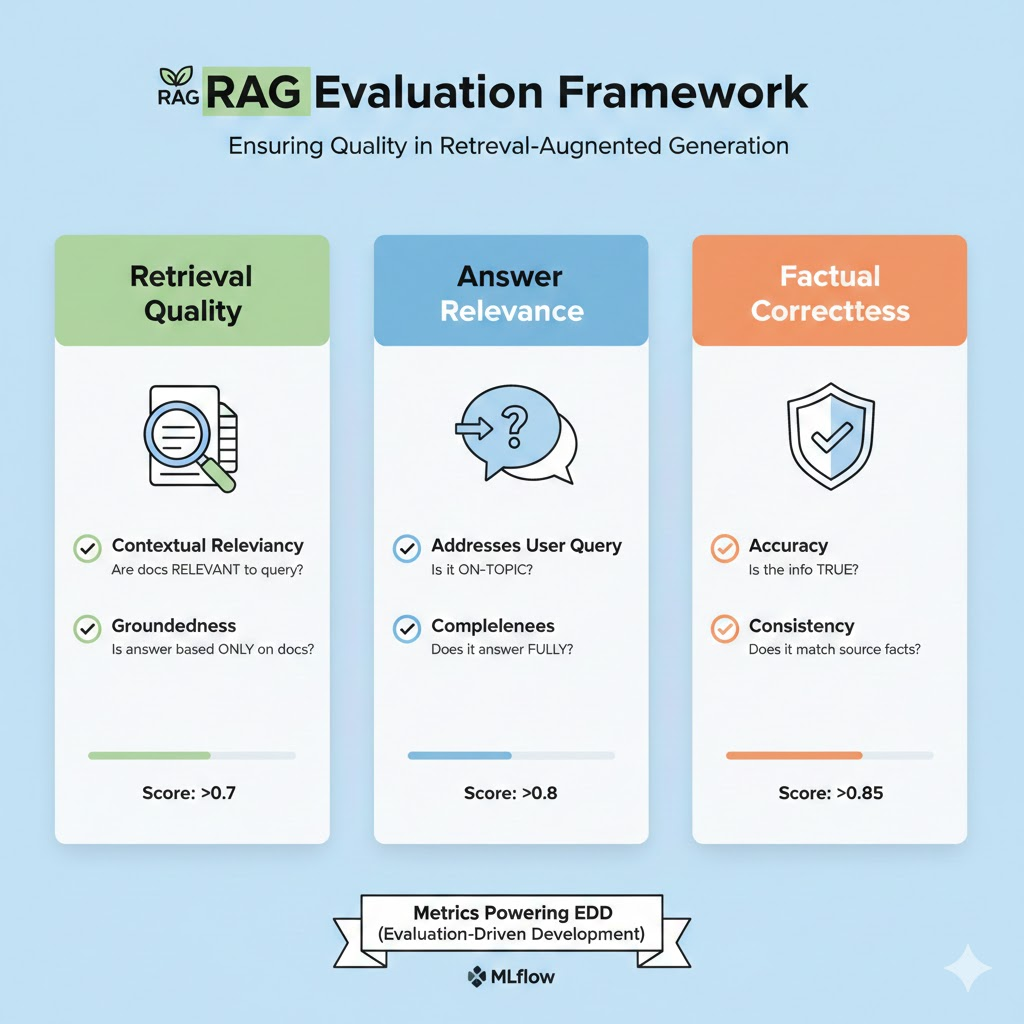

In [11]:
@scorer(name="Context Relevancy")
def contextual_relevancy(trace: Trace):
    """Evaluate RAG traces using DeepEval metrics"""
    
    data = _extract_deepeval_components(trace)

    # Define DeepEval metrics   
    

    # Create test cases
    test_case= LLMTestCase(
            input=data['input'],
            actual_output=data['actual_output'],
            retrieval_context=data['retrieval_context']
        )
    
    relevancy_metric = ContextualRelevancyMetric(threshold=0.7, model="gpt-4o-mini",
                                        include_reason=True)        
        
    # Run the metric evaluation
    relevancy_metric.measure(test_case)

    # Extract results
    score = relevancy_metric.score
    reason = relevancy_metric.reason

    return Feedback(
        value=score,
        rationale=reason,
    )

# Business-specific guidelines
business_guidelines = Guidelines(
    name="toxicity_clear",
    guidelines="""
    The response should avoid toxic language and adhere to community guidelines.
    """,
)

# Configure RAG-specific scorers
rag_scorers = [
    Correctness(
       # model="litellm_proxy:/amazon.nova-micro-v1:0",
    ),
    RelevanceToQuery(
        name="AnswerRelevance"
        #model="litellm_proxy:/amazon.nova-micro-v1:0",
    ),
    contextual_relevancy,
]


In [12]:
import mlflow

with mlflow.start_run(run_name="Simple Langgraph Agent"):

    eval_results = mlflow.genai.evaluate(
        data=rag_eval_dataset,
        predict_fn=qa_predict_rag_fn,
        scorers=rag_scorers,
    )

2025/11/24 21:14:12 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/11/24 21:14:13 INFO mlflow.genai.utils.data_validation: Testing model prediction with the first sample in the dataset. To disable this check, set the MLFLOW_GENAI_EVAL_SKIP_TRACE_VALIDATION environment variable to True.
2025/11/24 21:14:13 WARNING mlflow.tracing.fluent: Failed to start span LangGraph: 'NonRecordingSpan' object has no attribute 'context'. For full traceback, set logging level to debug.
Evaluating:   0%|          | 0/2 [Elapsed: 00:00, Remaining: ?] 

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Evaluating:  50%|█████     | 1/2 [Elapsed: 00:07, Remaining: 00:07] 

Evaluating: 100%|██████████| 2/2 [Elapsed: 00:09, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: Simple Langgraph Agent
  Run ID: 0cb62d5b82ef485cb37048232864abc9

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.



## 1.6 Running the RAG Evaluation

Now we'll run evaluation across our test cases. MLflow will:
1. Call `qa_predict_rag_fn()` for each test case
2. Capture the full trace (retrieval, reasoning, response)
3. Run each scorer against the trace
4. Aggregate results and track in MLflow UI

**What to Look For:**
- Do all scorers report > 0.7? (Good baseline)
- Do scores align? (If correctness is high but relevancy is low, something's wrong)
- Check MLflow UI for detailed per-test-case results

### Viewing RAG Evaluation Results

Below we display the aggregated metrics. You can also explore:
- **MLflow UI**: `mlflow ui` in terminal → Navigate to "GenAI_Eval_Demo" experiment
- **Per-test breakdown**: Drill into each test case to see which failed and why
- **Scorer reasoning**: Read the LLM judge's explanation for each score

💡 **Tip**: If scores are low, check:
1. Is the vector store returning relevant documents?
2. Is the agent system prompt clear?
3. Are test cases realistic?

---

# Part 2: Agent Evaluation – Building a CMS Management Agent

## 2.1 Scenario: Evaluating Agentic Tool Usage

**Problem:** We have an agent that manages CMS articles. We want to verify it:
1. ✓ Uses tools **efficiently** (no redundant calls)
2. ✓ Follows **standard operating procedures** (SOP)
3. ✓ Makes **logical decisions** based on tool outputs
4. ✓ **Completes tasks** correctly

**Example Scenario:**
- User: *"Find the Summer Recipes article and ensure it is published."*
- Smart agent: 
  1. Search for article (get ID)
  2. Get details (check current status)
  3. Skip publish (because it's already published) ← Key insight!
- Naive agent: Searches → Publishes anyway (redundant operation)

**Why This Matters:** 
In production, tool calls cost money (API fees) and time (latency). An agent that avoids unnecessary operations is more efficient. EDD helps us catch and fix these inefficiencies.

---

## 2.2 Setting Up the CMS Agent

### Our Mock Database

We'll use a simple in-memory database simulating article metadata:

In [13]:
# Mock Database
cms_db = {
    "101": {"title": "AI Trends 2024", "status": "draft", "tags": ["tech"]},
    "102": {"title": "Summer Recipes", "status": "published", "tags": ["food"]},
}

# We define expected output strings for our test cases to verify against
EXPECTED_SEARCH_OUTPUT_102 = str([{"id": "102", "title": "Summer Recipes", "status": "published"}])
EXPECTED_DETAILS_OUTPUT_102 = str({"title": "Summer Recipes", "status": "published", "tags": ["food"]})


# Tools 
@tool
def search_articles(query: str):
    """Searches for articles by title. Returns JSON string of matches."""
    # Simple logic to mimic a search engine
    results = [{"id": k, "title": v["title"], "status": v["status"]} 
               for k, v in cms_db.items() if query.lower() in v["title"].lower()]
    return str(results)

@tool
def get_article_details(article_id: str):
    """Gets full details for an ID."""
    return str(cms_db.get(article_id, "Article not found"))

@tool
def publish_article(article_id: str):
    """Publishes an article."""
    if article_id in cms_db:
        cms_db[article_id]["status"] = "published"
        return f"Success: Article {article_id} published."
    return "Error: ID not found."



In [14]:
# Setup Tools + LLM
cms_tools = [search_articles, get_article_details, publish_article]
chat_model = init_chat_model("gpt-4.1")

# Setup Prompt
agent_system_prompt = (
    "You are a CMS Manager. "
    "SOP: Always SEARCH for an article ID first. Never guess IDs. "
    "Before publishing, GET DETAILS to confirm the current status."
)

# Setup Agent
cms_agent = create_agent(model=chat_model, tools=cms_tools, system_prompt=agent_system_prompt)

# Prediction Function
def agent_predict_fn(query: str) -> str:
    response = cms_agent.invoke({
        "messages": [{"role": "user", "content": query}],
    })
    answer = response['messages'][-1].content
    return answer

### Agent Configuration: Tools & System Prompt

Our CMS manager has three tools:
1. **search_articles**: Find articles by title
2. **get_article_details**: Retrieve full metadata for an article
3. **publish_article**: Change status to "published"

Notice the system prompt: **"Always SEARCH for an article ID first. Never guess IDs."**

This establishes a **Standard Operating Procedure (SOP)** that we can later verify the agent follows. Good agents internalize this guidance; bad agents ignore it.

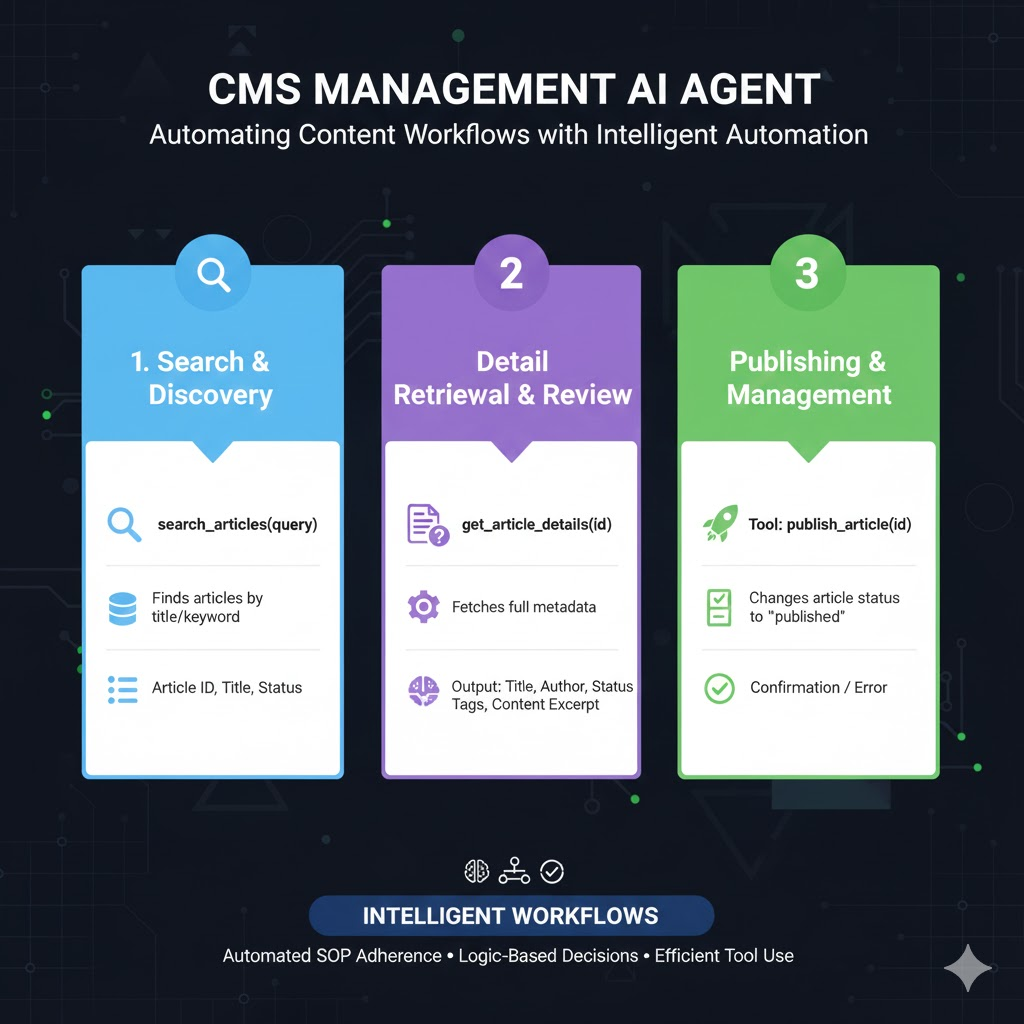

## 2.3 Designing Agent Test Cases

### Test Case 1: Simple Retrieval

**Query:** "What is the status of the Summer Recipes post?"
- Agent must call `search_articles` (to get ID)
- Expected trajectory: `[search_articles]`
- Task completion: High (straightforward lookup)

### Test Case 2: Complex Action with Logic

**Query:** "Find the Summer Recipes article and ensure it is published."
- Agent should call `search_articles` (get ID)
- Agent should call `get_article_details` (check current status)
- Agent should **NOT** call `publish_article` (it's already published!)
- Expected trajectory: `[search_articles, get_article_details]` ← No publish!
- Task completion: High (task is complete without republishing)

**Key Insight:** If the agent calls all three tools, it's being inefficient. Good evaluation catches this.

In [15]:
agent_eval_dataset = [
    # Case 1: Simple Retrieval
    {
        "inputs": {"query": "What is the status of the Summer Recipes post?"},
        "expectations": {
            "expected_response": "It is currently published.",
            "task_completion_threshold": 1.0,
            # The agent must call search, and the 'fact' it relies on is the tool output
            "expected_facts": [EXPECTED_SEARCH_OUTPUT_102], 
            "tool_call_trajectory": ["search_articles"]
        }
    },
    # Case 2: Complex Action (Search -> Check -> Publish)
    {
        "inputs": {"query": "Find the Summer Recipes article and ensure it is published."},
        "expectations": {
            "expected_response": "The article is already published.",
            # The agent should see the search result, AND the details showing it's published
            "expected_facts": [EXPECTED_SEARCH_OUTPUT_102, EXPECTED_DETAILS_OUTPUT_102],
            "tool_call_trajectory": ["search_articles", "get_article_details"] 
            # Note: It should NOT call publish_article because it sees it is already published
        }
    }
]

## 2.4 Custom Scorers for Agent Evaluation

### Scorer 1: Task Completeness (Using DeepEval)

**What It Measures:**
- Did the agent accomplish the stated task?
- Did it understand the requirements?
- Did it reach a logical conclusion?

**How It Works:**
1. Extract tool calls from trace (What did the agent actually do?)
2. Convert to DeepEval ToolCall objects
3. Create test case with tools used
4. DeepEval judges: "Given these tools, was the task completed?"

**Example:**
- Query: "Find the Summer Recipes article and ensure it is published"
- Tools used: [search_articles, get_article_details]
- Status quo: Article already published
- Judge decision: ✓ Task completed (republishing is redundant)

### Scorer 2: Tool Trajectory Analysis

**What It Measures:**
- Did the agent follow the expected tool call sequence?
- Is the trajectory logical given the inputs/outputs?

**How It Works:**
1. Extract actual tool calls from trace
2. Compare to expected trajectory from test case
3. Calculate match score (0.0 = no match, 1.0 = perfect match)
4. Provide detailed feedback

**Example:**
- Expected: `[search_articles, get_article_details]`
- Actual: `[search_articles, get_article_details, publish_article]`
- Match score: 0.67 (2/3 tools match, but extra call reduces efficiency)

---

### Implementing the Scorers

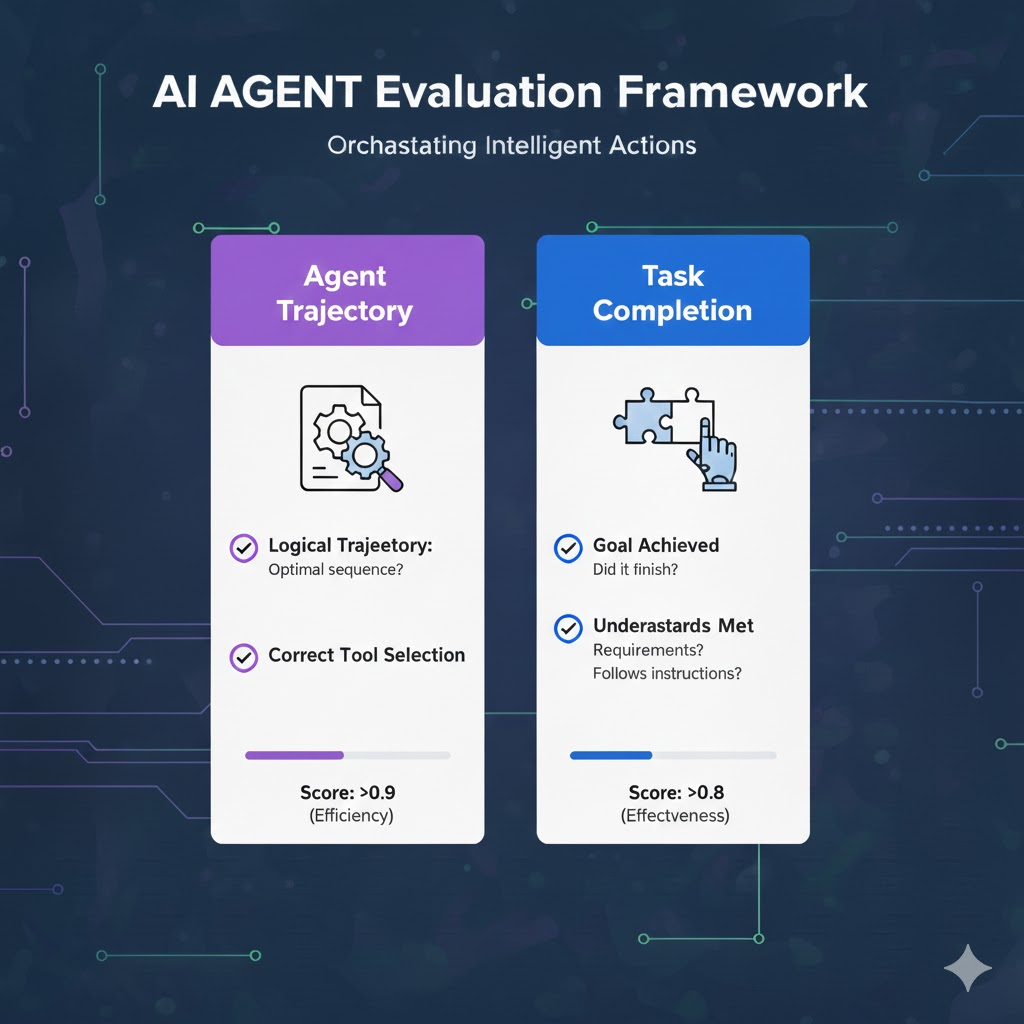

In [16]:


@scorer(name="Task Completeness")
def task_completion_with_deepeval(trace: Trace, inputs: dict, outputs: str, expectations: dict) -> Feedback:
    """
    Custom scorer that uses DeepEval's TaskCompletionMetric to evaluate task completion
    based on trace analysis and tool calls
    """

    try:
        # Extract tool call information from the trace
        tool_call_spans = trace.search_spans(span_type=SpanType.TOOL)

        # Convert MLflow trace tool calls to DeepEval ToolCall format
        tools_called = []
        for span in tool_call_spans:
            tool_call = ToolCall(
                name=span.name,
                description=span.attributes.get("description", f"Tool call for {span.name}"),
                input_parameters=span.inputs or {},
                output=span.outputs or []
            )
            tools_called.append(tool_call)

        # Extract the actual response text from the complex output structure
        if isinstance(outputs, dict):
            # Handle complex response structure
            if 'response' in outputs and 'blocks' in outputs['response']:
                actual_output = outputs['response']['blocks'][0]['text']
            elif 'response' in outputs and isinstance(outputs['response'], str):
                actual_output = outputs['response']
            else:
                actual_output = str(outputs)
        elif isinstance(outputs, str):
            actual_output = outputs
        else:
            actual_output = str(outputs)

        # Create DeepEval test case
        test_case = LLMTestCase(
            input=inputs.get("query", ""),
            actual_output=actual_output,
            tools_called=tools_called
        )

        # Initialize TaskCompletionMetric
        threshold = expectations.get("task_completion_threshold", 0.7)
        metric = TaskCompletionMetric(
            threshold=threshold,
            model="gpt-4o",  # Use consistent model
            include_reason=True
        )

        # Run the metric evaluation
        metric.measure(test_case)

        # Extract results
        score = metric.score
        reason = metric.reason

        return Feedback(
            value=score,
            rationale=f"Task completion score: {score:.2f} (threshold: {threshold}). Tools used: {len(tools_called)}. {reason}",
        )

    except Exception as e:
        return Feedback(
            value=0.0,
            rationale=f"Error evaluating task completion: {str(e)}",
            error=e
        )


@scorer(name="Tool Trajectory")
def tool_call_trajectory_analysis(trace: Trace, expectations: dict) -> Feedback:
    """
    Analyze the tool call trajectory against expected sequence
    """
    try:
        # Search for tool call spans in the trace
        tool_call_spans = trace.search_spans(span_type=SpanType.TOOL)

        # Extract actual trajectory
        actual_trajectory = [span.name for span in tool_call_spans]
        expected_trajectory = expectations.get("tool_call_trajectory", [])

        # Calculate trajectory match
        trajectory_match = actual_trajectory == expected_trajectory

        # Calculate partial match score
        if not expected_trajectory:
            partial_score = 1.0 if actual_trajectory else 0.0
        else:
            # Calculate sequence similarity
            min_len = min(len(actual_trajectory), len(expected_trajectory))
            max_len = max(len(actual_trajectory), len(expected_trajectory))
            if max_len == 0:
                partial_score = 1.0
            else:
                matches = sum(1 for i in range(min_len)
                             if i < len(actual_trajectory) and i < len(expected_trajectory)
                             and actual_trajectory[i] == expected_trajectory[i])
                partial_score = matches / max_len

        return Feedback(
            value=partial_score,
            rationale=(
                f"Tool trajectory {'matches' if trajectory_match else 'differs from'} expectations. "
                f"Expected: {expected_trajectory}. Actual: {actual_trajectory}. "
                f"Match score: {partial_score:.2f}"
            )
        )

    except Exception as e:
        return Feedback(
            value=0.0,
            rationale=f"Error analyzing tool trajectory: {str(e)}",
            error=e
        )
    

agent_scorers = [
    task_completion_with_deepeval,
    tool_call_trajectory_analysis,
]


## 2.5 Running the Agent Evaluation

Let's evaluate our CMS agent using the same MLflow infrastructure as the RAG agent.

In [17]:
import mlflow

with mlflow.start_run(run_name="Simple Langgraph CMS Agent"):

    eval_results = mlflow.genai.evaluate(
        data=agent_eval_dataset,
        predict_fn=agent_predict_fn,
        scorers=agent_scorers,
    )

2025/11/24 21:15:07 INFO mlflow.genai.utils.data_validation: Testing model prediction with the first sample in the dataset. To disable this check, set the MLFLOW_GENAI_EVAL_SKIP_TRACE_VALIDATION environment variable to True.
2025/11/24 21:15:07 WARNING mlflow.tracing.fluent: Failed to start span LangGraph: 'NonRecordingSpan' object has no attribute 'context'. For full traceback, set logging level to debug.
Evaluating:   0%|          | 0/2 [Elapsed: 00:00, Remaining: ?] 

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pedro.azevedo/dspt-mlflow/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Evaluating:  50%|█████     | 1/2 [Elapsed: 00:03, Remaining: 00:03] 

Evaluating: 100%|██████████| 2/2 [Elapsed: 00:05, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: Simple Langgraph CMS Agent
  Run ID: a77d1491668b4133a076296f1a2f1f8d

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.



In [20]:
eval_results.metrics

{'Tool Trajectory/mean': np.float64(0.75),
 'Task Completeness/mean': np.float64(0.85)}

### Interpreting Agent Evaluation Results

**Key Metrics to Check:**
- **Task Completeness**: Is it ≥ 0.8? (Agent understood and completed tasks)
- **Tool Trajectory Match**: Is it 1.0? (Agent followed expected call sequence)

**What Low Scores Mean:**
- Task Completeness < 0.7? Agent may not understand task requirements
- Trajectory < 1.0? Agent may be using tools redundantly or out of order

**Debugging Tips:**
1. Check MLflow UI: Drill into specific test case
2. Look at actual vs expected trajectory
3. Check final agent output—did it answer correctly?
4. Consider: Is your SOP clear enough? Might need better prompting

---

# Part 3: Synthesis & Key Takeaways

## What We've Accomplished

### RAG Evaluation
✓ Built a retrieval pipeline with multi-hop test cases  
✓ Configured scorers to verify both retrieval AND answer quality  
✓ Used MLflow to track evaluation runs and results  

### Agent Evaluation
✓ Built an agentic system with multiple tools  
✓ Designed test cases to verify efficiency AND correctness  
✓ Created custom scorers to analyze tool trajectories  

### EDD Workflow
✓ Automated evaluation that runs with every code change  
✓ Quantified metrics (not just "it seems good")  
✓ Trace-based debugging (see exactly what the agent did)  

---

## Key Principles of Evaluation-Driven Development

### 1. **Start with Clear Metrics**
Define what "good" means before you build. ("Correctness > 0.85", "No redundant tool calls")

### 2. **Design Realistic Test Cases**
Single-hop is easy; test multi-hop scenarios that reveal real issues.

### 3. **Use Automated Scoring**
LLM-as-a-judge is imperfect but beats manual review. Scale with confidence.

### 4. **Instrument for Debugging**
Traces are gold. Capture everything. You can always ignore data, but you can't recover what wasn't logged.

### 5. **Iterate Based on Metrics**
When a metric is low, **drill into traces to understand why**. Then fix the root cause (prompt, tools, data).

---

## Next Steps: From Workshop to Production

### For Your Own GenAI Application

**1. Map Components to Your System**
- What is your retrieval source? (Documents, APIs, databases)
- What are your key tools?
- What does "success" look like?

**2. Design Your Test Suite**
- Start with 5-10 critical test cases (not 100)
- Include edge cases that previously failed
- Update test suite as you discover new issues

**3. Set Baseline Metrics**
- Run evaluation today (establish "current state")
- Define target metrics (e.g., Correctness > 0.85)
- Evaluate before/after each change

**4. Integrate into CI/CD**
- Run evaluation on every commit
- Fail builds if metrics drop below threshold
- Use MLflow to track historical performance

**5. Iterate in a Feedback Loop**
```
Evaluate → Find Low Scores → Understand Why (via Traces) 
  → Improve (Prompt/Tools/Data) → Evaluate Again
```

### Tools & Resources
- **MLflow Docs**: https://mlflow.org/docs/latest/
- **LangChain Agents**: https://python.langchain.com/docs/modules/agents/
- **DeepEval Metrics**: https://docs.confident-ai.com/
- **OpenAI Evals**: https://github.com/openai/evals (for inspiration)

---

## Questions? Further Experimentation?

**Suggested Modifications to Try:**
1. Add a new test case that you expect to fail—does it?
2. Change the system prompt—how do scores change?
3. Add a fourth tool to the CMS agent—how does trajectory analysis adapt?
4. Lower the similarity threshold (k=1 → k=3)—does retrieval improve?

